In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: mps


In [2]:
def theta_exact_np(x,t):
    return ((np.pi / 2.0)*np.cos(x) + (x - np.pi/2.0)) * np.cos(t)

def w_exact_np(x, t):
    return (np.pi / 2.0) * np.sin(x) * np.cos(t)

def g_np(x,t):
    return np.cos(t) - (np.pi/2.0) * np.sin(x) * np.cos(t)

def add_relative_noise(arr, rel_std):
    eps = 1e-12
    scale = np.maximum(np.abs(arr), eps)
    noise = np.random.normal(0.0, rel_std, size=arr.shape)
    return arr + noise * scale

def to_torch(a):
    return torch.from_numpy(a).to(torch.float32)

def grad(y,x):
    return torch.autograd.grad(y,x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]

def split_theta_w(u):
    return u[:, :1], u[:, 1:2]

def to_device_batch(dct, device):
    out = {}
    for k, v in dct.items():
        out[k] = v.to(device) if torch.is_tensor(v) else v
    return out

In [3]:
def make_inverse_single_beam_data(
        Ni = 200, Nb=400, Nint = 1000, Ndata=5000,
        x_obs = (0.2, 0.8, 1.8, 2.6, 3.0),
        theta_rel_noise = 1e-6,
        w_rel_noise = 1e-5,
):
        # Collocation Points
        x_int = np.random.uniform(0.0, np.pi, size=(Nint, 1))
        t_int = np.random.uniform(0.0, 1.0, size=(Nint,1))
        g_int = g_np(x_int, t_int)

        # Initial Condition
        x_i = np.random.uniform(0.0, np.pi, size=(Ni,1))
        t_i = np.zeros((Ni,1))
        theta_i = theta_exact_np(x_i,t_i)
        w_i = w_exact_np(x_i, t_i)
        theta_t_i = np.zeros_like(theta_i)
        w_t_i = np.zeros_like(w_i)

        # Boundary Condition
        t_b = np.random.uniform(0.0,1.0,size=(Nb,1))
        half = Nb // 2
        x_b_left,  t_b_left  = np.zeros((half,1)), t_b[:half]
        x_b_right, t_b_right = np.full((Nb-half, 1), np.pi), t_b[half:]
        theta_b_left  = np.zeros_like(x_b_left)
        w_b_left      = np.zeros_like(x_b_left)
        theta_b_right = np.zeros_like(x_b_right)
        w_b_right     = np.zeros_like(x_b_right)

        # Observed data (noisy)
        per = Ndata // len(x_obs)
        rem = Ndata - per * len(x_obs)
        xs, ts = [], []
        for i, xl in enumerate(x_obs):
            n = per + (1 if i < rem else 0)
            xs.append(np.full((n,1), xl))
            ts.append(np.random.uniform(0.0,1.0, size=(n,1)))
        x_data = np.vstack(xs)
        t_data = np.vstack(ts)

        theta_data = theta_exact_np(x_data, t_data)
        w_data     = w_exact_np(x_data, t_data)
        theta_data_noisy = add_relative_noise(theta_data, theta_rel_noise)
        w_data_noisy     = add_relative_noise(w_data,     w_rel_noise)

        # Scaling bounds
        X_true = np.hstack((
            np.vstack([x_int, x_i, x_b_left, x_b_right, x_data]),
            np.vstack([t_int, t_i, t_b_left, t_b_right, t_data])
        ))
        lb = X_true.min(axis=0)
        ub = X_true.max(axis=0)

        data = {
            "x_int": to_torch(x_int), "t_int": to_torch(t_int), "g_int": to_torch(g_int),
            "x_i": to_torch(x_i), "t_i": to_torch(t_i),
            "theta_i": to_torch(theta_i), "w_i": to_torch(w_i),
            "theta_t_i": to_torch(theta_t_i), "w_t_i": to_torch(w_t_i),
            "x_b_left": to_torch(x_b_left), "t_b_left": to_torch(t_b_left),
            "theta_b_left": to_torch(theta_b_left), "w_b_left": to_torch(w_b_left),
            "x_b_right": to_torch(x_b_right), "t_b_right": to_torch(t_b_right),
            "theta_b_right": to_torch(theta_b_right), "w_b_right": to_torch(w_b_right),
            "x_data": to_torch(x_data), "t_data": to_torch(t_data),
            "theta_obs": to_torch(theta_data_noisy), "w_obs": to_torch(w_data_noisy),
            "lb": to_torch(lb),
            "ub": to_torch(ub),
        }
        return data

In [4]:
class PINN(nn.Module):
    def __init__(self, lower_bound, upper_bound, input_size = 2, hidden_size=20, output_size = 2, num_layers=4):
        super().__init__()
        lb = lower_bound.view(1,-1).to(torch.float32)
        ub = upper_bound.view(1,-1).to(torch.float32)
        self.register_buffer("lb", lb)
        self.register_buffer("ub", ub)

        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers-1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

        for m in self.network:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x = x.to(self.lb.device, dtype=torch.float32)
        x_scaled = (x - self.lb) / (self.ub - self.lb)
        y = self.network(x_scaled)
        return y  # [:,0]=θ, [:,1]=w

class PINN_Hard(nn.Module):
    def __init__(self, lower_bound, upper_bound, input_size = 2, hidden_size=20, output_size = 2, num_layers=4):
        super().__init__()
        lb = lower_bound.view(1,-1).to(torch.float32)
        ub = upper_bound.view(1,-1).to(torch.float32)
        self.register_buffer("lb", lb)
        self.register_buffer("ub", ub)

        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers-1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

        for m in self.network:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x = x.to(self.lb.device, dtype=torch.float32)

        # scale for NN
        x_scaled = (x - self.lb) / (self.ub - self.lb)
        y = self.network(x_scaled)         # raw outputs

        # hard BC envelope using *original* x (first column)
        xr = x[:, :1]                      # [N,1]
        s  = (4.0 / (torch.pi**2)) * xr * (torch.pi - xr)  # s(0)=s(π)=0, s∈[0,1]
        y_hard = torch.cat([s*y[:, :1], s*y[:, 1:2]], dim=1)
        return y_hard

In [5]:
def loss_pde(model, alpha, x_int, t_int, g_int):
    x = x_int.detach().requires_grad_(True)
    t = t_int.detach().requires_grad_(True)
    X = torch.cat([x,t], dim=1)

    u = model(X)
    theta, w = split_theta_w(u)

    theta_t  = grad(theta,t)
    theta_tt = grad(theta_t, t)
    w_t      = grad(w,t)
    w_tt     = grad(w_t, t)

    theta_x  = grad(theta, x)
    theta_xx = grad(theta_x, x)
    w_x      = grad(w,x)
    w_xx     = grad(w_x, x)

    eq1 = alpha * theta_tt - theta_xx + (theta - w_x)
    eq2 = w_tt + (theta_x - w_xx) - g_int

    loss_pde = (eq1**2).mean() + (eq2**2).mean()
    return loss_pde

def loss_ic(model, x_i, t_i, theta_i, w_i, theta_t_i, w_t_i):
    x = x_i.detach()
    t = t_i.detach().requires_grad_(True)
    X = torch.cat([x,t], dim=1)

    u = model(X)
    theta, w = split_theta_w(u)

    theta_t = grad(theta, t)
    w_t     = grad(w,t)

    loss_ic = ((theta-theta_i)**2).mean() + ((w-w_i)**2).mean() + \
              ((theta_t - theta_t_i)**2).mean() + ((w_t - w_t_i)**2).mean()
    return loss_ic

def loss_bc(model, x_bl, t_bl, theta_bl, w_bl, x_br, t_br, theta_br, w_br):
    xl = x_bl.detach().requires_grad_(True)
    tl = t_bl.detach().requires_grad_(True)
    Xl = torch.cat([xl, tl], dim=1)
    ul = model(Xl)
    th_l, w_l = split_theta_w(ul)

    xr = x_br.detach().requires_grad_(True)
    tr = t_br.detach().requires_grad_(True)
    Xr = torch.cat([xr, tr], dim=1)
    ur = model(Xr)
    th_r, w_r = split_theta_w(ur)

    loss_bc = ((th_l - theta_bl)**2).mean() + ((w_l - w_bl)**2).mean() + \
              ((th_r - theta_br)**2).mean() + ((w_r - w_br)**2).mean()
    return loss_bc

def loss_data(model, x_d, t_d, theta_obs, w_obs):
    Xd = torch.cat([x_d.detach(), t_d.detach()], dim=1)
    u = model(Xd)
    theta, w = split_theta_w(u)
    loss_data = ((theta - theta_obs)**2).mean() + ((w - w_obs)**2).mean()
    return loss_data

def total_loss(model, alpha, data, weights = (1.0, 1.0, 1.0, 1.0)):
    w_pde, w_ic, w_bc, w_data = weights
    lpde = loss_pde(model, alpha, data["x_int"], data["t_int"], data["g_int"])
    lic  = loss_ic(model, data["x_i"], data["t_i"], data["theta_i"], data["w_i"],
                   data["theta_t_i"], data["w_t_i"])
    lbc  = loss_bc(model,
                   data["x_b_left"], data["t_b_left"], data["theta_b_left"], data["w_b_left"],
                   data["x_b_right"], data["t_b_right"], data["theta_b_right"], data["w_b_right"])
    ldat = loss_data(model, data["x_data"], data["t_data"], data["theta_obs"], data["w_obs"])
    L = w_pde*lpde + w_ic*lic + w_bc*lbc + w_data*ldat
    terms = {"pde": lpde.detach(), "ic": lic.detach(), "bc": lbc.detach(), "data": ldat.detach()}
    return L, terms

In [6]:
def train_pinn(model, alpha, data, epochs = 5000, lr = 1.0, weights = (1.0, 1.0, 1.0, 1.0)):
    optimizer = optim.LBFGS(
        list(model.parameters()) + [alpha],
        lr=lr,
        max_iter=1,
        history_size=100,
        line_search_fn="strong_wolfe"
    )
    losses = []
    pbar = tqdm(range(epochs), desc="Training PINN (L-BFGS)")
    for ep in pbar:
        def closure():
            optimizer.zero_grad()
            L, terms = total_loss(model, alpha, data, weights)
            L.backward()
            closure.loss, closure.terms = L, terms
            return L
        optimizer.step(closure)
        L, terms = closure.loss, closure.terms
        losses.append(L.item())
        if ep % 100 == 0:
            pbar.set_postfix({
                "Loss": f"{L.item():.3e}",
                "PDE": f"{terms['pde'].item():.2e}",
                "IC": f"{terms['ic'].item():.2e}",
                "BC": f"{terms['bc'].item():.2e}",
                "DATA": f"{terms['data'].item():.2e}",
                "alpha": f"{alpha.item():.6f}",
            })
    pbar.close()
    return model, alpha, losses

In [7]:
@torch.no_grad()
def evaluate_boundary_stats(model, data):
    """Mean/Max of predicted |theta|, |w| at boundary points"""
    # left
    Xl = torch.cat([data["x_b_left"], data["t_b_left"]], dim=1)
    ul = model(Xl)
    th_l, w_l = split_theta_w(ul)
    # right
    Xr = torch.cat([data["x_b_right"], data["t_b_right"]], dim=1)
    ur = model(Xr)
    th_r, w_r = split_theta_w(ur)

    th_all = torch.cat([th_l, th_r], dim=0).abs()
    w_all  = torch.cat([w_l,  w_r],  dim=0).abs()

    stats = {
        "theta_mean": th_all.mean().item(),
        "theta_max":  th_all.max().item(),
        "w_mean":     w_all.mean().item(),
        "w_max":      w_all.max().item(),
    }
    return stats

@torch.no_grad()
def plot_boundary_scatter(models, labels, data):
    colors = ["C0", "C3", "C2", "C1"]
    plt.figure(figsize=(7,5))
    # 왼쪽 경계 x=0
    tL = data["t_b_left"].detach().cpu().numpy().ravel()
    # 오른쪽 경계 x=π
    tR = data["t_b_right"].detach().cpu().numpy().ravel()
    for i, (model, lab) in enumerate(zip(models, labels)):
        # left
        yL = model(torch.cat([data["x_b_left"], data["t_b_left"]], dim=1))
        thL, wL = split_theta_w(yL)
        # right
        yR = model(torch.cat([data["x_b_right"], data["t_b_right"]], dim=1))
        thR, wR = split_theta_w(yR)

        thL = thL.detach().cpu().numpy().ravel()
        wL  = wL.detach().cpu().numpy().ravel()
        thR = thR.detach().cpu().numpy().ravel()
        wR  = wR.detach().cpu().numpy().ravel()

        # 왼쪽
        plt.scatter(tL, thL, s=8, alpha=0.5, color=colors[i%len(colors)], label=f"{lab}: θ @x=0")
        plt.scatter(tL, wL,  s=8, alpha=0.5, color=colors[i%len(colors)], marker='x', label=f"{lab}: w @x=0")
        # 오른쪽
        plt.scatter(tR, thR, s=8, alpha=0.5, color=colors[i%len(colors)], label=f"{lab}: θ @x=π")
        plt.scatter(tR, wR,  s=8, alpha=0.5, color=colors[i%len(colors)], marker='x', label=f"{lab}: w @x=π")

    plt.axhline(0.0, color="k", lw=1)
    plt.xlabel("t"); plt.ylabel("prediction at boundary")
    plt.title("Boundary predictions (soft vs hard)")
    plt.legend(fontsize=8, ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Training PINN (L-BFGS): 100%|██████████| 5000/5000 [08:15<00:00, 10.10it/s, Loss=3.590e-06, PDE=3.25e-06, IC=2.76e-07, BC=0.00e+00, DATA=6.31e-08, alpha=1.001175]



[SOFT] alpha = 0.995850
[HARD] alpha = 1.001175


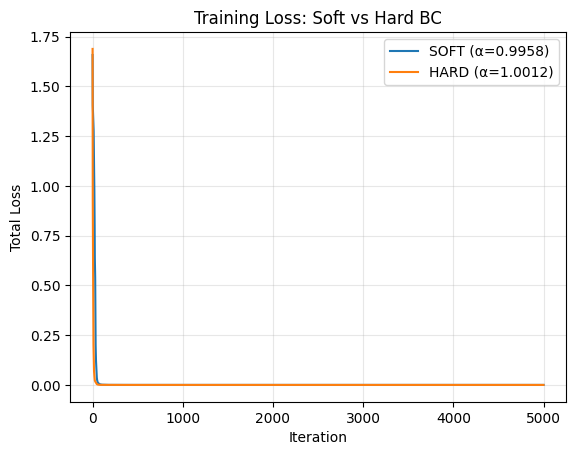


Boundary |prediction| stats
SOFT : theta_mean=3.146e-04, theta_max=1.257e-03, w_mean=8.234e-04, w_max=3.545e-03
HARD : theta_mean=0.000e+00, theta_max=0.000e+00, w_mean=0.000e+00, w_max=0.000e+00


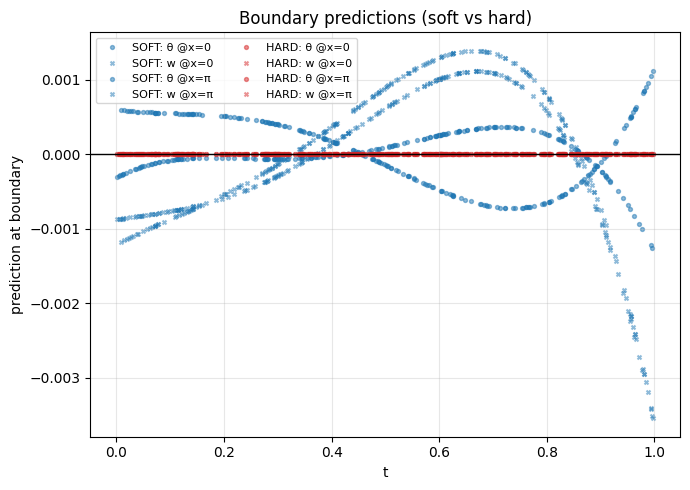

In [8]:
# 1) build data (noisy), move to device
data = make_inverse_single_beam_data()
data = to_device_batch(data, device)
lower_bound = data["lb"]; upper_bound = data["ub"]

epochs = 5000

# ---- SOFT ----
torch.manual_seed(42); np.random.seed(42)
model_soft = PINN(lower_bound, upper_bound, input_size=2, hidden_size=20, output_size=2, num_layers=4).to(device)
alpha_soft = nn.Parameter(torch.tensor([1.0], dtype=torch.float32, device=device), requires_grad=True)
model_soft_tr, alpha_soft_tr, losses_soft = train_pinn(
    model_soft, alpha_soft, data,
    epochs=epochs, lr=1.0, weights=(1.0, 1.0, 1.0, 1.0)
)

# ---- HARD ----
torch.manual_seed(42); np.random.seed(42)
model_hard = PINN_Hard(lower_bound, upper_bound, input_size=2, hidden_size=20, output_size=2, num_layers=4).to(device)
alpha_hard = nn.Parameter(torch.tensor([1.0], dtype=torch.float32, device=device), requires_grad=True)
model_hard_tr, alpha_hard_tr, losses_hard = train_pinn(
    model_hard, alpha_hard, data,
    epochs=epochs, lr=1.0, weights=(1.0, 1.0, 0.0, 1.0)
)

# ======================
# Compare results
# ======================
a_s = alpha_soft_tr.item()
a_h = alpha_hard_tr.item()
print(f"\n[SOFT] alpha = {a_s:.6f}")
print(f"[HARD] alpha = {a_h:.6f}")

plt.figure()
plt.plot(losses_soft, label=f"SOFT (α={a_s:.4f})")
plt.plot(losses_hard, label=f"HARD (α={a_h:.4f})")
plt.xlabel("Iteration"); plt.ylabel("Total Loss")
plt.title("Training Loss: Soft vs Hard BC")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# Boundary statistics (how well BC satisfied)
stats_soft = evaluate_boundary_stats(model_soft_tr, data)
stats_hard = evaluate_boundary_stats(model_hard_tr, data)
print("\nBoundary |prediction| stats")
print("SOFT : theta_mean={:.3e}, theta_max={:.3e}, w_mean={:.3e}, w_max={:.3e}".format(
    stats_soft["theta_mean"], stats_soft["theta_max"], stats_soft["w_mean"], stats_soft["w_max"]))
print("HARD : theta_mean={:.3e}, theta_max={:.3e}, w_mean={:.3e}, w_max={:.3e}".format(
    stats_hard["theta_mean"], stats_hard["theta_max"], stats_hard["w_mean"], stats_hard["w_max"]))

# Scatter plot at boundaries to visually compare
plot_boundary_scatter([model_soft_tr, model_hard_tr], ["SOFT", "HARD"], data)
